In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import statsmodels.api as sm

DATA_DIR = Path('.')
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import matplotlib as mpl
mpl.rcParams["axes.formatter.useoffset"] = False

In [3]:
pd.set_option('display.max_columns', None)

## Read in data + clean up

In [4]:
with pd.ExcelFile(DATA_DIR / 'royalty analysis by network for python.xlsx') as xls:
    BBDO = pd.read_excel(xls, 'BBDO', header=0, index_col=1)

In [5]:
t1 = BBDO.copy()

# Aggregate at country level

In [6]:
t1 = t1.reset_index().copy()

In [7]:
t1 = t1.groupby('Country').sum()

In [8]:
del t1['Network']

In [9]:
t1['OECD'] = t1['OECD'].apply(lambda x: 1 if x > 0 else 0)

## Read in CT rates

In [10]:
# Read in CT rates data
with pd.ExcelFile(DATA_DIR / 'CT rates uptp2016.xlsx') as xls:
    ctrates = pd.read_excel(xls, 'Raw', header=0, index_col=0)

In [11]:
# For countries missing 2016 CT rates, replace with their 2015 value (e.g. Switzerland)
ctrates.loc[ctrates[2016].isnull(), 2016] = ctrates.loc[ctrates[2016].isnull(), 2015]

In [12]:
# Which countries in t1 not in ctrates?
set(BBDO.index).difference(set(ctrates.index))

{'Korea', 'Puerto Rico'}

In [13]:
# Rename these
country_name_map = {
    'Hong Kong SAR': 'Hong Kong',
    'Korea, Republic of': 'Korea',
    'Slovakia': 'Slovak Republic'
} 
ctrates.index = pd.Series(ctrates.index).apply(lambda x: country_name_map[x] if x in country_name_map else x)

In [14]:
set(t1.index).difference(set(ctrates.index))

{'Puerto Rico'}

In [15]:
puerto_rico = pd.DataFrame({'Location': ['Puerto Rico'], 2016: [39]}).set_index('Location')

In [16]:
ctrates = ctrates.append(puerto_rico)

In [17]:
t1 = t1.reset_index()

In [18]:
t1.head()

,Country,Unrelated Parties Revenue,Related Parties Revenue,Total Revenue,Profit (Loss) Before Tax,Income Tax Accrued - CY,Income Tax Paid including WHT,Stated Capital,Number of Employees,Tangible Assets,OECD
0,Australia,1.930092e+08,6559396.72,1.995686e+08,12759512.97,2.274793e+07,8.424168e+06,46636286.77,964.4,5498738.89,1
1,Austria,7.532889e+06,62449.67,7.595339e+06,1323571.70,3.239944e+05,5.154408e+05,92347.50,67.0,264208.84,1
2,Belgium,2.705165e+07,365445.19,2.741710e+07,4861091.95,1.853325e+06,1.561525e+06,289910.99,202.0,248522.43,1
3,Brazil,7.837679e+07,85793.30,7.846259e+07,23339618.92,7.872262e+06,8.498725e+06,2581719.78,398.0,3813943.53,0
4,Canada,2.791965e+07,1764969.03,2.968462e+07,2646121.60,-1.096016e+06,1.106869e+06,48155362.18,177.0,3755638.20,1


In [19]:
# Get rid of indexes
t1.columns = ['Country'] + list(t1.columns.values)[1:]

In [20]:
ctrates = ctrates.reset_index()

In [21]:
ctrates = ctrates[['Location', 2016]]

In [22]:
ctrates.columns = ['Country', 'CTRate']

In [23]:
# Merge ctrates in
t1 = pd.merge(left=t1, right=ctrates, on='Country')

# Ratios

In [24]:
t1.columns

Index(['Country', 'Unrelated Parties Revenue', 'Related Parties Revenue',
       'Total Revenue', 'Profit (Loss) Before Tax', 'Income Tax Accrued - CY',
       'Income Tax Paid including WHT', 'Stated Capital',
       'Number of Employees', 'Tangible Assets', 'OECD', 'CTRate'],
      dtype='object')

In [25]:
# CTRate is current percentage out of 100
t1['CTRate'] = t1.CTRate.apply(lambda x: x / 100)

In [26]:
# Effective Tax Rate
t1['ETR'] = t1['Income Tax Paid including WHT'] / t1['Profit (Loss) Before Tax']

In [27]:
# Tax Elasticity
t1['TaxElasticity'] = t1['ETR'] / t1['CTRate']

In [28]:
# Operating Margin
t1['OM'] = t1['Profit (Loss) Before Tax'] / t1['Total Revenue']

In [29]:
# Related Party Revenue Intensity
t1['RPInt'] = t1['Related Parties Revenue'] / t1['Total Revenue']

In [30]:
# Employee Intensity
t1['AssetPerEE'] = t1['Tangible Assets'] / t1['Number of Employees']
t1['PBTPerEE'] = t1['Profit (Loss) Before Tax'] / t1['Number of Employees']

In [31]:
# Return On Capital
t1['ROC'] = t1['Profit (Loss) Before Tax'] / t1['Stated Capital']

In [32]:
t1.head()

,Country,Unrelated Parties Revenue,Related Parties Revenue,Total Revenue,Profit (Loss) Before Tax,Income Tax Accrued - CY,Income Tax Paid including WHT,Stated Capital,Number of Employees,Tangible Assets,OECD,CTRate,ETR,TaxElasticity,OM,RPInt,AssetPerEE,PBTPerEE,ROC
0,Australia,1.930092e+08,6559396.72,1.995686e+08,12759512.97,2.274793e+07,8.424168e+06,46636286.77,964.4,5498738.89,1,0.3000,0.660226,2.200755,0.063935,0.032868,5701.720127,13230.519463,0.273596
1,Austria,7.532889e+06,62449.67,7.595339e+06,1323571.70,3.239944e+05,5.154408e+05,92347.50,67.0,264208.84,1,0.2500,0.389432,1.557727,0.174261,0.008222,3943.415522,19754.801493,14.332513
2,Belgium,2.705165e+07,365445.19,2.741710e+07,4861091.95,1.853325e+06,1.561525e+06,289910.99,202.0,248522.43,1,0.3399,0.321229,0.945070,0.177301,0.013329,1230.309059,24064.811634,16.767533
3,Brazil,7.837679e+07,85793.30,7.846259e+07,23339618.92,7.872262e+06,8.498725e+06,2581719.78,398.0,3813943.53,0,0.3400,0.364133,1.070979,0.297462,0.001093,9582.772688,58642.258593,9.040338
4,Canada,2.791965e+07,1764969.03,2.968462e+07,2646121.60,-1.096016e+06,1.106869e+06,48155362.18,177.0,3755638.20,1,0.2650,0.418298,1.578485,0.089141,0.059457,21218.294915,14949.839548,0.054950


## Import activities data

> **NOTE:** Commenting this all out as we don't have activity data at network-country level.

In [33]:
#with pd.ExcelFile(DATA_DIR / '2016 CbC Report Table 2 used for python.xlsx') as xls:
#    t2 = pd.read_excel(xls, sheetname='Table 2', header=1)

In [34]:
# Drop cols we don't need
#for col in ['Reviewer', '10/50 or CFC', 'Tax Jurisdiction', 'LEN #', 'Other- Specify',
#            'Number of full time equivalent employees at year-end',
#            'Number of full time equivalent contractors/consultants at year-end']:
#    del t2[col]

In [35]:
# Drop dormant companies
#print(t2.Dormant.unique())
#t2 = t2[t2['Dormant'].str.lower() != 'yes'].copy()
#print(t2.Dormant.unique())
#del t2['Dormant']

In [36]:
# Coerce activities to numeric
#activity_cols = [
#    'Research and Development',
#    'Holding or Management of Intellectual Property',
#    'Purchasing or Procurement', 'Manufacturing or Production',
#    'Sales/ Marketing or Distribution',
#    'Administrative/Management or Support Services',
#    'Provision of Services to Unrelated Parties', 'Internal Group Finance',
#    'Regulated Financial Services', 'Insurance',
#    'Holding Shares or Other Equity Instruments'
#]

In [37]:
# Options...
#np.unique(t2[activity_cols])

In [38]:
#for activity_col in activity_cols:
#    t2[activity_col] = t2[activity_col].apply(lambda x: str(x).lower().replace(' ', '')).map({'yes': 1, 'no': 0})

In [39]:
# Aggregate avg activity by country
#t2_country = t2.groupby('Country Of Business').mean().reset_index()

In [40]:
# Let's have a look
#t2_country.head()

In [41]:
# What's the difference here?
#t2_country.sort_values('Sales/ Marketing or Distribution').head()

## Join t1 and t2

In [42]:
# What's in t1 and not in t2?
#set(t1['Country']) - set(t2_country['Country Of Business'])

In [43]:
# What's in t2 and not in t1?
#set(t2_country['Country Of Business']) - set(t1['Country'])

In [44]:
# Can we drop Tanzania from t1? Yes...by looks of it.
#t1[t1['Country'] == 'Tanzania']

In [45]:
# Drop Tanzania from t1
#t1 = t1[t1['Country'] != 'Tanzania'].copy()

In [46]:
# Can we drop Barbados from t2?
#t2[t2['Country Of Business'] == 'Barbados']

In [47]:
# Drop Barbados from t2_country
#t2_country = t2_country[t2_country['Country Of Business'] != 'Barbados'].copy()

In [48]:
# Rename Korea, Qatar, Slovakia in t2
#country_mapping = {
#    'Korea, Republic of': 'Korea',
#    'Qatar (Katar)': 'Qatar',
#    'Slovakia': 'Slovak Republic'
#}
#t2_country['Country Of Business'] = t2_country['Country Of Business'].apply(
#    lambda x: country_mapping[x] if x in country_mapping else x
#)

In [49]:
# CHECK: What's in t1 and not in t2?
#set(t1['Country']) - set(t2_country['Country Of Business'])

In [50]:
# CHECK: What's in t2 and not in t1?
#set(t2_country['Country Of Business']) - set(t1['Country'])

In [51]:
# Ready to merge!
#df = pd.merge(
#    left=t1,
#    right=t2_country,
#    left_on='Country',
#    right_on='Country Of Business'
#    )

In [52]:
#del df['Country Of Business']

In [53]:
df = t1.copy()
df.head()

,Country,Unrelated Parties Revenue,Related Parties Revenue,Total Revenue,Profit (Loss) Before Tax,Income Tax Accrued - CY,Income Tax Paid including WHT,Stated Capital,Number of Employees,Tangible Assets,OECD,CTRate,ETR,TaxElasticity,OM,RPInt,AssetPerEE,PBTPerEE,ROC
0,Australia,1.930092e+08,6559396.72,1.995686e+08,12759512.97,2.274793e+07,8.424168e+06,46636286.77,964.4,5498738.89,1,0.3000,0.660226,2.200755,0.063935,0.032868,5701.720127,13230.519463,0.273596
1,Austria,7.532889e+06,62449.67,7.595339e+06,1323571.70,3.239944e+05,5.154408e+05,92347.50,67.0,264208.84,1,0.2500,0.389432,1.557727,0.174261,0.008222,3943.415522,19754.801493,14.332513
2,Belgium,2.705165e+07,365445.19,2.741710e+07,4861091.95,1.853325e+06,1.561525e+06,289910.99,202.0,248522.43,1,0.3399,0.321229,0.945070,0.177301,0.013329,1230.309059,24064.811634,16.767533
3,Brazil,7.837679e+07,85793.30,7.846259e+07,23339618.92,7.872262e+06,8.498725e+06,2581719.78,398.0,3813943.53,0,0.3400,0.364133,1.070979,0.297462,0.001093,9582.772688,58642.258593,9.040338
4,Canada,2.791965e+07,1764969.03,2.968462e+07,2646121.60,-1.096016e+06,1.106869e+06,48155362.18,177.0,3755638.20,1,0.2650,0.418298,1.578485,0.089141,0.059457,21218.294915,14949.839548,0.054950


## Bring in royalties

In [54]:
with pd.ExcelFile(DATA_DIR / 'royalty analysis by network for python.xlsx') as xls:
    royalty = pd.read_excel(xls, 'Royalty summary', header=0)

In [55]:
# Network specific data only
network = 'BBDO'
royalty = royalty[royalty['Network'] == network].copy()
royalty

,Network,Charging country,Charging office,Paying country,Ave Roy
10,BBDO,US,OIHI,UK,2.00
11,BBDO,US,OIHI,Canada,3.00
12,BBDO,US,OIHI,Germany,1.58


In [56]:
# Cleanup
#royalties = royalties[royalties['Network'].notnull()]
royalty = royalty[['Paying country', 'Ave Roy']].copy()
#royalties = royalties[royalties['Royalties %'].notnull()]
#royalties['Paying country'].ffill(limit=None, inplace=True)
#royalties = royalties[royalties['Paying country'] != '?']
royalty

,Paying country,Ave Roy
10,UK,2.00
11,Canada,3.00
12,Germany,1.58


In [57]:
# Group by country
#royalty_country_avg = royalty.groupby('Paying country').mean().reset_index()
#royalty_country_avg

In [58]:
# What's in royalties_country_avg and not in df?
set(royalty['Paying country']) - set(df['Country'])

{'UK '}

In [59]:
# Map country names to df
country_mapping = {'Germany ': 'Germany', 'UK ': 'United Kingdom'}
royalty['Paying country'] = royalty['Paying country'].apply(
    lambda x: country_mapping[x] if x in country_mapping else x
)
royalty

,Paying country,Ave Roy
10,United Kingdom,2.00
11,Canada,3.00
12,Germany,1.58


In [60]:
# CHECK: What's in royalties_country_avg and not in df?
set(royalty['Paying country']) - set(df['Country'])

set()

In [61]:
royalty

,Paying country,Ave Roy
10,United Kingdom,2.00
11,Canada,3.00
12,Germany,1.58


In [62]:
# Add this to df
df = pd.merge(
    left=df,
    right=royalty,
    left_on='Country',
    right_on='Paying country',
    how='left'
)

In [63]:
del df['Paying country']
df['royalty'] = df['Ave Roy'].fillna(0.0)
del df['Ave Roy']

In [64]:
df

,Country,Unrelated Parties Revenue,Related Parties Revenue,Total Revenue,Profit (Loss) Before Tax,Income Tax Accrued - CY,Income Tax Paid including WHT,Stated Capital,Number of Employees,Tangible Assets,OECD,CTRate,ETR,TaxElasticity,OM,RPInt,AssetPerEE,PBTPerEE,ROC,royalty
0,Australia,1.930092e+08,6559396.72,1.995686e+08,12759512.97,2.274793e+07,8.424168e+06,46636286.77,964.40,5498738.89,1,0.3000,0.660226,2.200755,0.063935,0.032868,5701.720127,1.323052e+04,2.735962e-01,0.00
1,Austria,7.532889e+06,62449.67,7.595339e+06,1323571.70,3.239944e+05,5.154408e+05,92347.50,67.00,264208.84,1,0.2500,0.389432,1.557727,0.174261,0.008222,3943.415522,1.975480e+04,1.433251e+01,0.00
2,Belgium,2.705165e+07,365445.19,2.741710e+07,4861091.95,1.853325e+06,1.561525e+06,289910.99,202.00,248522.43,1,0.3399,0.321229,0.945070,0.177301,0.013329,1230.309059,2.406481e+04,1.676753e+01,0.00
3,Brazil,7.837679e+07,85793.30,7.846259e+07,23339618.92,7.872262e+06,8.498725e+06,2581719.78,398.00,3813943.53,0,0.3400,0.364133,1.070979,0.297462,0.001093,9582.772688,5.864226e+04,9.040338e+00,0.00
4,Canada,2.791965e+07,1764969.03,2.968462e+07,2646121.60,-1.096016e+06,1.106869e+06,48155362.18,177.00,3755638.20,1,0.2650,0.418298,1.578485,0.089141,0.059457,21218.294915,1.494984e+04,5.494968e-02,3.00
5,Chile,1.155036e+07,-150536.51,1.139983e+07,2202584.50,6.763700e+05,0.000000e+00,13578.13,154.00,116040.34,1,0.2400,0.000000,0.000000,0.193212,-0.013205,753.508701,1.430250e+04,1.622156e+02,0.00
6,China,5.537370e+07,2311227.50,5.768493e+07,13476782.37,3.217653e+06,3.744882e+06,549342.30,450.00,494095.83,0,0.2500,0.277877,1.111506,0.233627,0.040066,1097.990733,2.994841e+04,2.453258e+01,0.00
7,Colombia,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,834205.29,991.00,2420451.11,0,0.2500,NaN,NaN,NaN,NaN,2442.433007,0.000000e+00,0.000000e+00,0.00
8,Croatia,3.995480e+06,28185.70,4.023665e+06,700336.21,9.748240e+04,1.692902e+05,32150.93,72.00,10878.36,0,0.2000,0.241727,1.208635,0.174054,0.007005,151.088333,9.726892e+03,2.178277e+01,0.00
9,Czech Republic,5.389155e+06,25845.02,5.415000e+06,816853.04,1.606617e+05,6.371982e+04,83427.89,120.01,14047.05,1,0.1900,0.078006,0.410560,0.150850,0.004773,117.048996,6.806541e+03,9.791127e+00,0.00


## Prepare df for classification

In [65]:
# Dummy country
#country_dummies = pd.get_dummies(df['Country'])
#model_df = pd.concat([df, country_dummies.ix[:, 1:]], axis=1)

In [66]:
# Coerce royalty to binary 1/0
df['charge_royalty'] = (df['royalty'] > 0).astype(int)

In [67]:
df

,Country,Unrelated Parties Revenue,Related Parties Revenue,Total Revenue,Profit (Loss) Before Tax,Income Tax Accrued - CY,Income Tax Paid including WHT,Stated Capital,Number of Employees,Tangible Assets,OECD,CTRate,ETR,TaxElasticity,OM,RPInt,AssetPerEE,PBTPerEE,ROC,royalty,charge_royalty
0,Australia,1.930092e+08,6559396.72,1.995686e+08,12759512.97,2.274793e+07,8.424168e+06,46636286.77,964.40,5498738.89,1,0.3000,0.660226,2.200755,0.063935,0.032868,5701.720127,1.323052e+04,2.735962e-01,0.00,0
1,Austria,7.532889e+06,62449.67,7.595339e+06,1323571.70,3.239944e+05,5.154408e+05,92347.50,67.00,264208.84,1,0.2500,0.389432,1.557727,0.174261,0.008222,3943.415522,1.975480e+04,1.433251e+01,0.00,0
2,Belgium,2.705165e+07,365445.19,2.741710e+07,4861091.95,1.853325e+06,1.561525e+06,289910.99,202.00,248522.43,1,0.3399,0.321229,0.945070,0.177301,0.013329,1230.309059,2.406481e+04,1.676753e+01,0.00,0
3,Brazil,7.837679e+07,85793.30,7.846259e+07,23339618.92,7.872262e+06,8.498725e+06,2581719.78,398.00,3813943.53,0,0.3400,0.364133,1.070979,0.297462,0.001093,9582.772688,5.864226e+04,9.040338e+00,0.00,0
4,Canada,2.791965e+07,1764969.03,2.968462e+07,2646121.60,-1.096016e+06,1.106869e+06,48155362.18,177.00,3755638.20,1,0.2650,0.418298,1.578485,0.089141,0.059457,21218.294915,1.494984e+04,5.494968e-02,3.00,1
5,Chile,1.155036e+07,-150536.51,1.139983e+07,2202584.50,6.763700e+05,0.000000e+00,13578.13,154.00,116040.34,1,0.2400,0.000000,0.000000,0.193212,-0.013205,753.508701,1.430250e+04,1.622156e+02,0.00,0
6,China,5.537370e+07,2311227.50,5.768493e+07,13476782.37,3.217653e+06,3.744882e+06,549342.30,450.00,494095.83,0,0.2500,0.277877,1.111506,0.233627,0.040066,1097.990733,2.994841e+04,2.453258e+01,0.00,0
7,Colombia,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,834205.29,991.00,2420451.11,0,0.2500,NaN,NaN,NaN,NaN,2442.433007,0.000000e+00,0.000000e+00,0.00,0
8,Croatia,3.995480e+06,28185.70,4.023665e+06,700336.21,9.748240e+04,1.692902e+05,32150.93,72.00,10878.36,0,0.2000,0.241727,1.208635,0.174054,0.007005,151.088333,9.726892e+03,2.178277e+01,0.00,0
9,Czech Republic,5.389155e+06,25845.02,5.415000e+06,816853.04,1.606617e+05,6.371982e+04,83427.89,120.01,14047.05,1,0.1900,0.078006,0.410560,0.150850,0.004773,117.048996,6.806541e+03,9.791127e+00,0.00,0


## Build logit classification model

In [68]:
from sklearn import linear_model

In [69]:
# Tunisia contains NaNs and infs, it has zero revenue, so drop it
df = df[df['Country'] != 'Tunisia'].copy()

# Drop the US
df = df[df['Country'] != 'United States'].copy()

In [70]:
#country_features = list(country_dummies.ix[:, 1:].columns.values)

In [71]:
df.columns

Index(['Country', 'Unrelated Parties Revenue', 'Related Parties Revenue',
       'Total Revenue', 'Profit (Loss) Before Tax', 'Income Tax Accrued - CY',
       'Income Tax Paid including WHT', 'Stated Capital',
       'Number of Employees', 'Tangible Assets', 'OECD', 'CTRate', 'ETR',
       'TaxElasticity', 'OM', 'RPInt', 'AssetPerEE', 'PBTPerEE', 'ROC',
       'royalty', 'charge_royalty'],
      dtype='object')

In [72]:
features = [
    'Unrelated Parties Revenue',
    'Profit (Loss) Before Tax',
    'Stated Capital',
    'Number of Employees',
    'Tangible Assets',
    #'CTRate',
    #'ETR',
    #'TaxElasticity',
    #'OM',
    #'RPInt',
    #'AssetPerEE',
    #'PBTPerEE',
    #'ROC',
    'OECD',
]

In [73]:
X = df[features]
y = df['charge_royalty']

In [74]:
model = linear_model.LogisticRegression()

In [75]:
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [76]:
model.score(X, y)

0.82222222222222219

In [77]:
coefs = pd.DataFrame(data={'feature': X.columns, 'coef': model.coef_[0], 'abs_coef': np.abs(model.coef_[0])},
                     columns=['feature', 'coef', 'abs_coef'])
coefs.sort_values('abs_coef', ascending=False)

,feature,coef,abs_coef
3,Number of Employees,-8.078418e-07,8.078418e-07
4,Tangible Assets,2.511152e-07,2.511152e-07
1,Profit (Loss) Before Tax,-1.940801e-07,1.940801e-07
2,Stated Capital,-3.734951e-08,3.734951e-08
0,Unrelated Parties Revenue,1.667134e-08,1.667134e-08
5,OECD,-5.453479e-09,5.453479e-09


### Interpretation
Controlling for all other variables...
- The log-odds of charging royalty increases by -8.078418e-07 for every additional employee
  - i.e. more employees means less likely to charge royalty

In [78]:
# P(charge_royalty | OECD) = 3/22 = 14%
# P(charge_royalty | not OECD) = 0%
pd.crosstab(df['OECD'], df['charge_royalty'])

charge_royalty,0,1
OECD,,
0,20,0
1,22,3


## Build regression model (`royalty ~ .`)

In [79]:
features = [
    'Unrelated Parties Revenue',
    'Profit (Loss) Before Tax',
    'Stated Capital',
    'Number of Employees',
    'Tangible Assets',
    #'CTRate',
    #'ETR',
    #'TaxElasticity',
    #'OM',
    #'RPInt',
    #'AssetPerEE',
    #'PBTPerEE',
    #'ROC',
    'OECD',
]

In [80]:
X = df[features]
y = df['royalty']

In [81]:
model = linear_model.LinearRegression()

In [82]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [83]:
model.score(X, y)

0.47685748072009804

In [84]:
coefs = pd.DataFrame(data={'feature': X.columns, 'coef': model.coef_, 'abs_coef': np.abs(model.coef_)},
                     columns=['feature', 'coef', 'abs_coef'])
coefs.sort_values('abs_coef', ascending=False)

,feature,coef,abs_coef
5,OECD,1.043812e-01,1.043812e-01
3,Number of Employees,8.039626e-05,8.039626e-05
4,Tangible Assets,1.301104e-07,1.301104e-07
1,Profit (Loss) Before Tax,4.186309e-08,4.186309e-08
2,Stated Capital,2.901708e-08,2.901708e-08
0,Unrelated Parties Revenue,-7.845699e-09,7.845699e-09


### Interpretation
Controlling for all other variables...
- Being an OECD country (on average) means average royalty increases by 0.104%
- For every additional employee we see a increase of 0.00000804% (on average, i.e. including all non-OECD countries too, which may not make sense here as number of employees may be collinear with OECD...a model that can explicitly control for this conditional relationship may be a more sensible approach)
- Assets, Profits, Capital all positively correlated.
- Unrelated Parties Revenue negatively correlated.

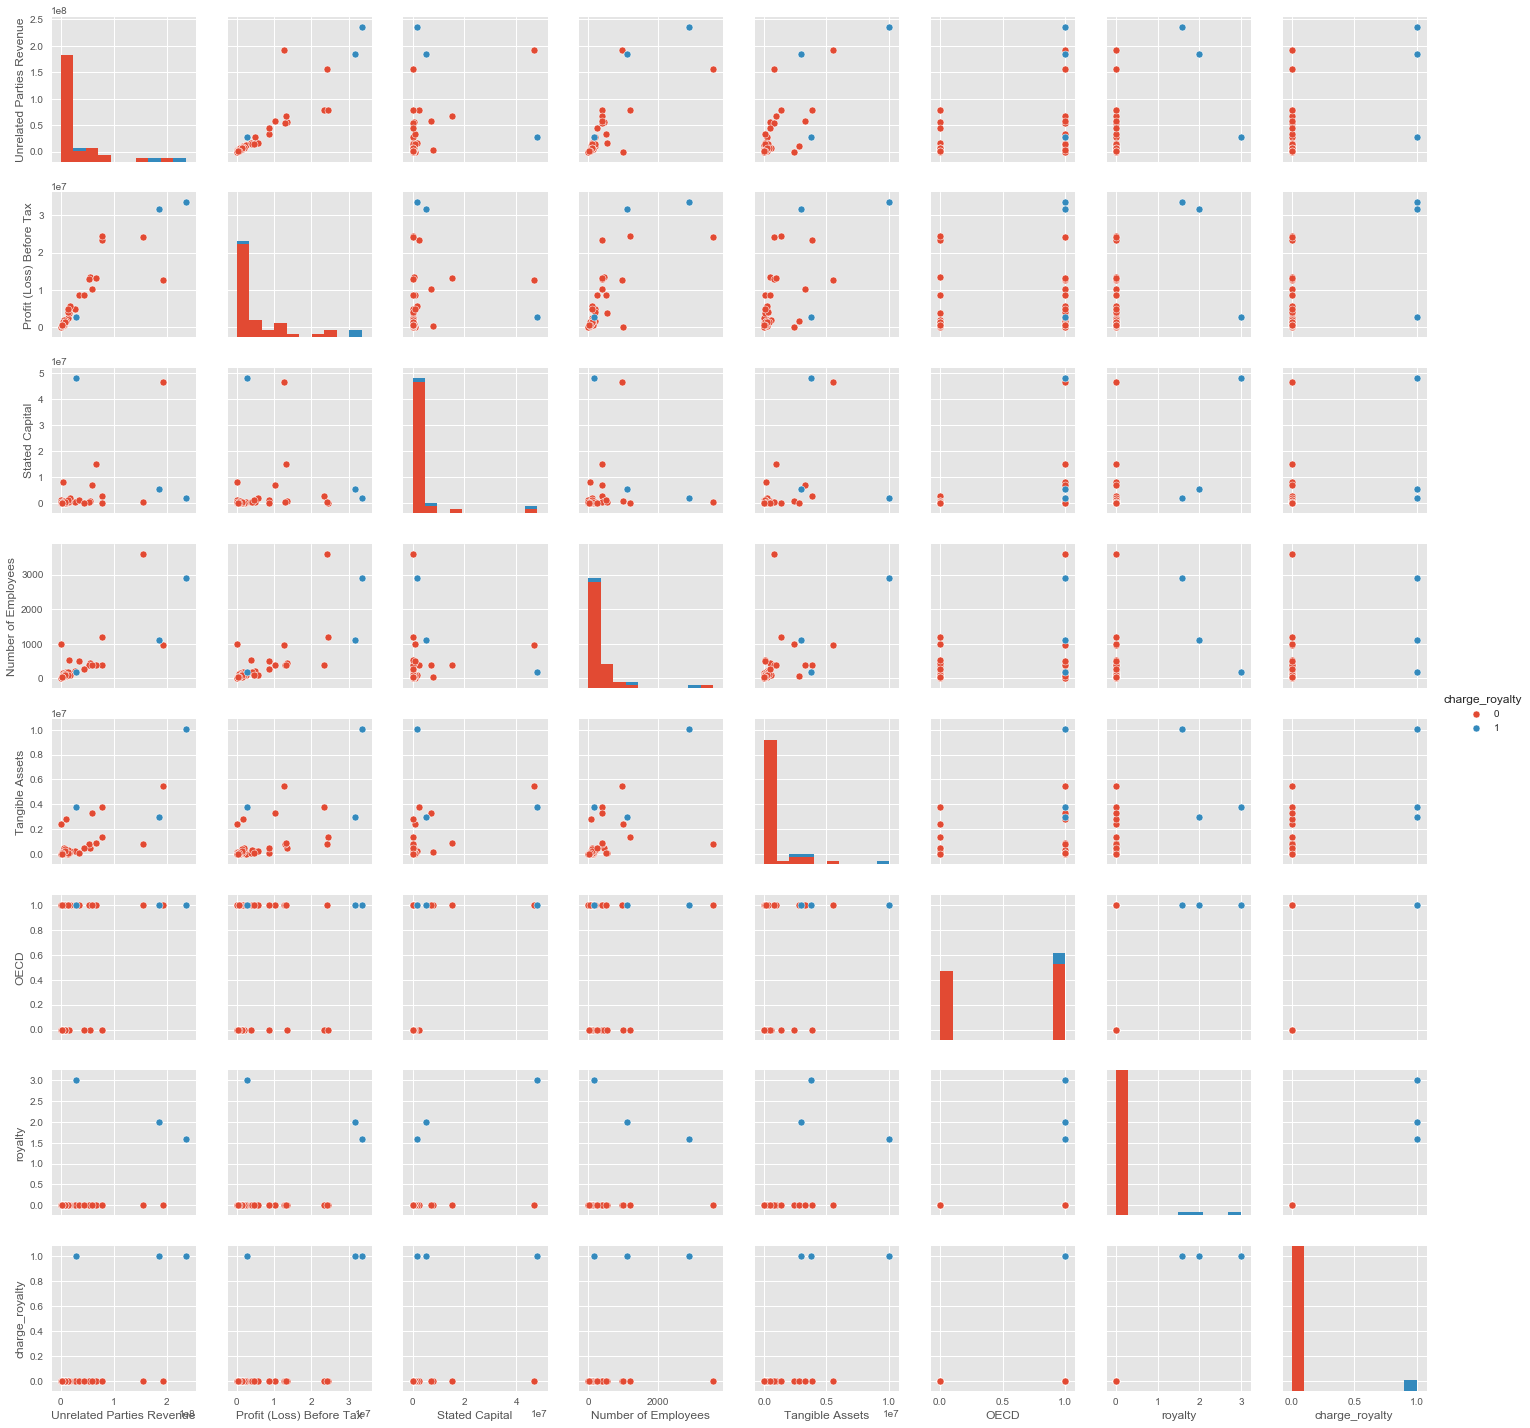

In [85]:
sns.pairplot(df[features + ['royalty', 'charge_royalty']], hue='charge_royalty')

In [86]:
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                royalty   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     6.135
Date:                Fri, 21 Jul 2017   Prob (F-statistic):           0.000135
Time:                        12:42:42   Log-Likelihood:                -24.910
No. Observations:                  45   AIC:                             61.82
Df Residuals:                      39   BIC:                             72.66
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Unrelated Parties Revenue -6.252e-09   4.29e-09     -1.457      0.153     -1.49e-08  2.43e-09
Profit (Loss) Before Tax   3.241e-08   1.96e-08      1.655      0.106     -7.21e-09   7.2e-08
Stated Capital             2.741e-08   9.26e-09      2.961      0.005      8.68e-09  4.61e-08
Number of Employees        5.273e-05      0.000      0.298      0.767        -0.000     0.000
Tangible Assets            1.234e-07   6.07e-08      2.032      0.049      5.66e-10  2.46e-07
OECD                         -0.0192      0.111     -0.174      0.863        -0.244     0.205
==============================================================================
Omnibus:                       28.865   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.444
Skew:                           1.466   Prob(JB):                     1.14e-21
Kurtosis:                       9.545   Cond. No.                     1.07e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Add ratios as features to regression model

In [87]:
features = [
    #'Unrelated Parties Revenue',
    #'Profit (Loss) Before Tax',
    #'Stated Capital',
    #'Number of Employees',
    #'Tangible Assets',
    #'CTRate',
    'ETR',
    #'TaxElasticity',
    'OM',
    #'RPInt',
    'AssetPerEE',
    'PBTPerEE',
    'ROC',
    'OECD',
]

In [88]:
X = df[features]
y = df['royalty']

In [89]:
# Handle infinities
X = X.replace(np.inf, 0.0).copy()
X = X.replace(-np.inf, 0.0).copy()

In [90]:
# Handle missing data
X = X.fillna(0)

In [91]:
model = linear_model.LinearRegression()

In [92]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [93]:
model.score(X, y)

0.18959387931027372

In [94]:
coefs = pd.DataFrame(data={'feature': X.columns, 'coef': model.coef_, 'abs_coef': np.abs(model.coef_)},
                     columns=['feature', 'coef', 'abs_coef'])
coefs.sort_values('abs_coef', ascending=False)

,feature,coef,abs_coef
0,ETR,0.538715,0.538715
5,OECD,0.195062,0.195062
1,OM,-0.012214,0.012214
2,AssetPerEE,0.000024,0.000024
3,PBTPerEE,-0.000004,0.000004
4,ROC,-0.000002,0.000002


### Interpretation
Controlling for all other variables...
- ETR, OECD, AssetPerEE positively correlated
- OM, PBTPerEE, ROC negatively correlated

## Build decision tree classification model (`charge_royalty ~ .`)

In [95]:
from sklearn import tree

In [96]:
features = [
    'Unrelated Parties Revenue',
    'Profit (Loss) Before Tax',
    'Stated Capital',
    'Number of Employees',
    'Tangible Assets',
    #'CTRate',
    #'ETR',
    #'TaxElasticity',
    #'OM',
    #'RPInt',
    #'AssetPerEE',
    #'PBTPerEE',
    #'ROC',
    'OECD',
]

In [97]:
X = df[features]
y = df['charge_royalty']

In [98]:
model = tree.DecisionTreeClassifier()

In [99]:
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [100]:
model.score(X, y)

1.0

In [105]:
import pydotplus
from IPython.display import Image

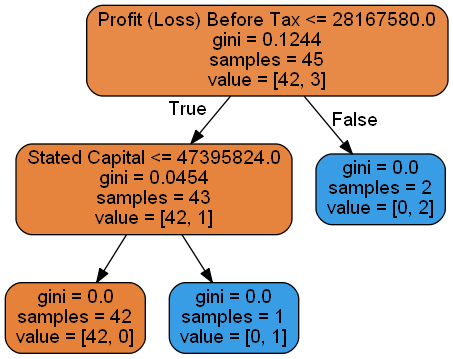

In [106]:
dot_data = tree.export_graphviz(
    model,
    out_file=None, 
    feature_names=X.columns,
    filled=True,
    rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

```
If profit > 28m then charge royalties.
Otherwise, is stated capital > 47m also charge royalties.
Otherwise, do not charge royalties.
```

In [107]:
# gini: the lower the better, purity score, Value[x,y] X - number of countries in that leaf that has 0 royalty, Y is has royalty
# 45 countries out of which 42 don't charge roylaty, if pbt >28.1m then charge royalty, otherwise if less than 28m but less than
#47m state capital 